In [1]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxesBlazeFace import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_encoder_decoder.ssd_input_encoder_blazeface import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize

%matplotlib inline

Using TensorFlow backend.
/workspace/blazeface_keras/data_generator/object_detection_2d_data_generator.py:44: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [2]:
# Set the image size.
img_height = 128
img_width = 128

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[[0.2, math.sqrt(0.2 * 0.43)], [0.43, math.sqrt(0.43 * 0.67), 0.67, math.sqrt(0.67 * 0.9), 0.9, math.sqrt(0.9 * 1)]], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
                steps=[64, 128],
                offsets=None,
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.1,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/blazeface_with_landmark_simple_v2_epoch-30_loss-4.1291.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

------------------y_pred-------------------
Tensor("predictions/concat:0", shape=(None, None, 24), dtype=float32)
----------------coords------------------------
Tensor("decoded_predictions/sub:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/sub_1:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/add_2:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/add_3:0", shape=(None, None), dtype=float32)
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


In [4]:
train_images_dir = "../BlazeFace/data/WIDER_train/images/"
train_anno_file = "./data/train_annos_simple.csv"

train_dataset = DataGenerator(load_images_into_memory=None, hdf5_dataset_path=None)

# Ground truth
train_labels_filename = train_anno_file


train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax','kp1_x','kp1_y','kp2_x','kp2_y','kp3_x','kp3_y','kp4_x','kp4_y','kp5_x','kp5_y','class_id'],
                        include_classes='all')

In [5]:
batch_size = 32
predictor_sizes = [(16,16),(8,8)]
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [[0.2, math.sqrt(0.2 * 0.43)], [0.43, math.sqrt(0.43 * 0.67), 0.67, math.sqrt(0.67 * 0.9), 0.9, math.sqrt(0.9 * 1)]]
aspect_ratios = [[1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]] # The anchor box aspect ratios
steps = [64, 128] # The space between two adjacent anchor box center points for each predictor layer.
offsets = None # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)


ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

train_generator = train_dataset.generate(batch_size=batch_size,
                                        shuffle=True,
                                        transformations=[ssd_data_augmentation],
                                        label_encoder=ssd_input_encoder,
                                        returns={'processed_images',
                                                'encoded_labels',
                                                'filenames'},
                                        keep_images_without_gt=normalize_coords)

In [6]:
a = next(train_generator)

In [38]:
a[1]

array([[[ 0.  ,  1.  ,  2.8 , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 0.  ,  1.  ,  0.4 , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 0.  ,  1.  , -2.4 , ...,  0.1 ,  0.2 ,  0.2 ],
        ...,
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ]],

       [[ 0.  ,  1.  , 17.85, ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        ...,
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ]],

       [[ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        ...,
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
        [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.

In [24]:
a[0].shape

(32, 128, 128, 3)

In [39]:
for i in range(896):
    print(a[1][1][i])

[  0.     1.    17.85   7.99 -14.66 -11.2   17.58   7.99  17.85   7.99  17.85   8.26
  17.58   8.52  17.85   8.52   0.25   0.25   0.29   0.29   0.1    0.1    0.2    0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.75
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.25
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.25
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.75
 0.25 0.29 0.29 0.1  0.1  0.2  0.2 ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.75
 0.25

In [36]:
a[1][19]

array([[ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
       [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
       [ 0.  ,  1.  , -7.06, ...,  0.1 ,  0.2 ,  0.2 ],
       ...,
       [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
       [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ],
       [ 1.  ,  0.  ,  0.  , ...,  0.1 ,  0.2 ,  0.2 ]])

In [27]:
a[2][17]


'../BlazeFace/data/WIDER_train/images/56--Voter/56_Voter_peoplevoting_56_170.jpg'

In [7]:
confidence_thresh=0.01
iou_threshold=0.45
nms_max_output_size=400
normalize_coords=False
coords='centroids'
top_k = 200
decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')


In [8]:
y_pred = tf.convert_to_tensor(a[1])
y_pred = tf.cast(y_pred,tf.float32)
output = decoded_predictions.call(y_pred)

------------------y_pred-------------------
tf.Tensor(
[[[1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  ...
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]]

 [[0.         1.         5.1948786  ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [0.         1.         2.3976364  ... 0.1        0.2        0.2       ]
  ...
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]
  [1.         0.         0.         ... 0.1        0.2        0.2       ]]

 [[1.         0.         0.         ... 0

In [9]:
output[0]

<tf.Tensor: shape=(200, 16), dtype=float32, numpy=
array([[1.       , 1.       , 0.6796875, ..., 0.6171875, 0.6875   ,
        0.6171875],
       [1.       , 1.       , 0.6328125, ..., 0.6484375, 0.640625 ,
        0.6484375],
       [1.       , 1.       , 0.5546875, ..., 0.6484375, 0.5625   ,
        0.6484375],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

In [10]:
confidence_threshold = 0.6
print(output.shape)
y_pred_thresh = [output[k][output[k,:,1] > confidence_threshold] for k in range(output.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class    conf     xmin     ymin     xmax     ymax    kp1_x   kp1_y   kp2_x    kp2_y   kp3_x     kp3_y    kp4_x    kp4_y   kp5_x   kp5_y')
print(y_pred_thresh[0])
print(y_pred_thresh[0].shape)

(32, 200, 16)
Predicted boxes:

   class    conf     xmin     ymin     xmax     ymax    kp1_x   kp1_y   kp2_x    kp2_y   kp3_x     kp3_y    kp4_x    kp4_y   kp5_x   kp5_y
tf.Tensor(
[[1.   1.   0.68 0.61 0.7  0.62 0.69 0.62 0.7  0.62 0.69 0.62 0.69 0.62 0.69 0.62]
 [1.   1.   0.63 0.64 0.64 0.65 0.64 0.64 0.64 0.64 0.64 0.65 0.64 0.65 0.64 0.65]
 [1.   1.   0.55 0.64 0.56 0.65 0.55 0.64 0.56 0.64 0.56 0.64 0.55 0.65 0.56 0.65]
 [1.   1.   0.59 0.66 0.59 0.66 0.59 0.66 0.59 0.66 0.59 0.66 0.59 0.66 0.59 0.66]
 [1.   1.   0.81 0.61 0.82 0.62 0.81 0.61 0.81 0.61 0.82 0.61 0.81 0.62 0.81 0.62]], shape=(5, 16), dtype=float32)
(5, 16)


In [12]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = './data/widerface/train/images/3--Riot/3_Riot_Riot_3_454.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)
print(img.shape)

(128, 128, 3)


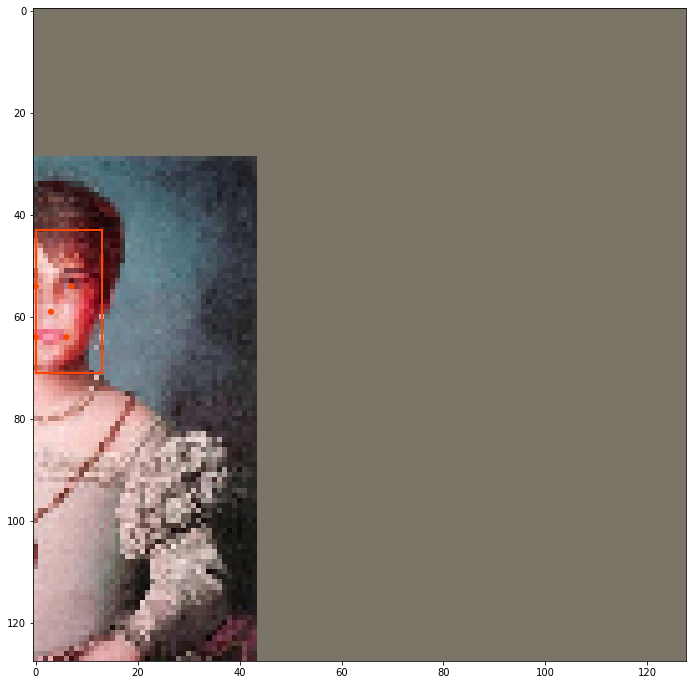

In [23]:
# Display the image and draw the predicted boxes onto it.
from PIL import Image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'face']

plt.figure(figsize=(20,12))
# plt.imshow(orig_images[0])
plt.imshow(Image.fromarray(a[0][11]))
current_axis = plt.gca()
# print(orig_images[0].shape[1])
# print(orig_images[0].shape[0])

for box in y_pred_thresh[11]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * img_width#* orig_images[0].shape[1] / img_width 
    ymin = box[3] * img_height#* orig_images[0].shape[0] / img_height
    xmax = box[4] * img_width#* orig_images[0].shape[1] / img_width 
    ymax = box[5] * img_height#* orig_images[0].shape[0] / img_height
    kp1_x = box[6] * img_width#* orig_images[0].shape[1] / img_width
    kp1_y = box[7] * img_height#* orig_images[0].shape[0] / img_height
    kp2_x = box[8] * img_width#* orig_images[0].shape[1] / img_width
    kp2_y = box[9] * img_height#* orig_images[0].shape[0] / img_height
    kp3_x = box[10] * img_width#* orig_images[0].shape[1]/ img_width
    kp3_y = box[11] * img_height#* orig_images[0].shape[0]/ img_height
    kp4_x = box[12] * img_width#* orig_images[0].shape[1]/ img_width
    kp4_y = box[13] * img_height#* orig_images[0].shape[0]/ img_height
    kp5_x = box[14] * img_width#* orig_images[0].shape[1]/ img_width
    kp5_y = box[15] * img_height#* orig_images[0].shape[0]/ img_height
    
    
    
    color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.add_patch(plt.Circle((kp1_x,kp1_y),0.5,color=color))
    current_axis.add_patch(plt.Circle((kp2_x,kp2_y),0.5,color=color))
    current_axis.add_patch(plt.Circle((kp3_x,kp3_y),0.5,color=color))
    current_axis.add_patch(plt.Circle((kp4_x,kp4_y),0.5,color=color))
    current_axis.add_patch(plt.Circle((kp5_x,kp5_y),0.5,color=color))
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.text(xmin, ymin, '', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'data/widerface/val/images/49--Greeting/49_Greeting_peoplegreeting_49_456.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [ ]:
confidence_threshold = 0.6
print(y_pred.shape)
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class    conf     xmin     ymin     xmax     ymax    kp1_x   kp1_y   kp2_x    kp2_y   kp3_x     kp3_y    kp4_x    kp4_y   kp5_x   kp5_y')
print(y_pred_thresh[0])
print(y_pred_thresh[0].shape)

In [ ]:
predictor_sizes = [(16,16),(8,8)]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)